# You need to install:
git clone https://github.com/jpierel14/tweakreg_hack

cd tweakreg_hack

pip install .

### IMPORTANT! This routine does only fix the wcs info in the wcs 'asdf' extension of the fits image. It does NOT update the approximate WCS solution in the fits header (yet, we are working on  it). Here is an example how you can convert from x,y to ra,dec and back using the updated WCS info in the asdf extension:

from jwst import datamodels

image_model = datamodels.ImageModel('jw01018003001_02101_00001_nrca1_tweakregstep.fits')

world_to_detector = image_model.meta.wcs.get_transform('world', 'detector')

x, y = world_to_detector(ra,dec)

detector_to_world = image_model.meta.wcs.get_transform('detector', 'world')

ra, dec = detector_to_world(x,y)


In [11]:
from jwst_wcs_align import jwst_wcs_align
from jwst.datamodels import ImageModel
import re,os
from jwst_wcs_align import initplot, rotate_d_and_find_binmax, sigmacut_d_rot, infoplots
import matplotlib.pyplot as plt

#input_image='/ifs/jwst/wit/nircam/commissioning/01069/obsnum2/jw01069002004_06101_00002_nrcb3_cal.fits'
#distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrcb3_full_f200w_clear.distcoeff.asdf'
#input_image='/ifs/jwst/wit/nircam/commissioning/01069/obsnum2/jw01069002002_02101_00002_nrca1_cal.fits'
#distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrca1_full_f070w_clear.distcoeff.asdf'
#input_image='/ifs/jwst/wit/nircam/commissioning/01074/obsnum3/jw01074003001_04101_00002_nrcb3_cal.fits'
#distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrcb3_full_f150w_clear.distcoeff.asdf'
input_image='/user/arest/wcs_align_exampleimages/jw01069002004_02101_00002_nrcblong_tweakregstep.fits'
distortion_file = '/Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrcb5_full_f444w_clear.distcoeff.asdf'

### output will be saved in  f'{outrootdir}/{outsubdir}'
### !!!!!! Choose the appropriate outdir!
outrootdir = './test'
outsubdir = 'wcs_align/v1'
wcs_align = jwst_wcs_align()
verbose=2
wcs_align.verbose=verbose
wcs_align.set_outdir(outrootdir, outsubdir)
### get some info about the image
image_model = ImageModel(input_image)
print(f'Info: outdir:{wcs_align.outdir}\n{os.path.basename(input_image)}: {image_model.meta.aperture.name} {image_model.meta.instrument.filter} {image_model.meta.instrument.pupil}')

Info: outdir:/Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats
jw01069002004_02101_00002_nrcblong_tweakregstep.fits: NRCB5_FULL F444W CLEAR


In [12]:
overwrite = True
skip_applydistortions_if_exists=False
skip_if_exists = False
#refcatname = './LMC_gaia_DR3.nrcposs'
refcatname = 'gaia'
refcat_racol = None # if None, then set automatically
refcat_deccol = None # if None, then set automatically
pmflag = False
pm_median = False
photfilename = 'auto'
load_photcat_if_exists = False
rematch_refcat = True
use_dq=False
DNunits=True
SNR_min = 10
d2d_max = None # maximum distance refcat to source in image
dmag_max = 0.1 # maximum uncertainty of source 
sharpness_lim = (0.4,0.9)
#delta_mag_lim = (-30,-28) # limits on mag-refcat_mainfilter for FGS!
delta_mag_lim = (-26.5,-24.0) # limits on mag-refcat_mainfilter for NRC W filters! 
Nbright4match=3000 # Use only the brightest Nbright4match sources to match to the refcat catalog
Nbright= 1000  # Use only the brightest Nbright sources from image
# showplots=0: no plots
# showplots=1: important plots
# showplots=2: all plots
# showplots=3: debug plots
showplots=2
saveplots=1
savephottable=2


In [13]:
# apply distortion coefficients if wanted.
# the output file with the new distortions has the suffix _assignwcsstep.fits
if distortion_file is not None:
    # apply distortion terms
    (runflag,calimname) = wcs_align.run_applydistortions(input_image,
                                                    distortion_file,
                                                    overwrite = overwrite, 
                                                    skip_if_exists = (skip_applydistortions_if_exists |  skip_if_exists))
else:
    calimname = input_image
    photfilename = re.sub('\.fits$','',os.path.basename(input_image))
    photfilename = f'{wcs_align.outdir}/{photfilename}.phot.txt'
print(f'Done!\nimage: {calimname}\nphotometry file: {photfilename}')

2022-07-01 13:55:32,323 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


This is NOT a rate.fits file! Therefore just applying the distortions with AssignWcsStep
assigning WCS to file /user/arest/wcs_align_exampleimages/jw01069002004_02101_00002_nrcblong_tweakregstep.fits using distortion file /Users/arest/nircam/jwst_distortions_tools/final_CRDS/v1.2/nrcb5_full_f444w_clear.distcoeff.asdf
Setting output directory for assignwcsstep.fits file to /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats
Creating /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.fits


2022-07-01 13:55:34,225 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/user/arest/wcs_align_exampleimages/jw01069002004_02101_00002_nrcblong_tweakregstep.fits',).
2022-07-01 13:55:34,227 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-07-01 13:55:39,833 - stpipe.AssignWcsStep - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/asdf/asdf.py:348: AsdfWarning: File 'file:///grp/crds/cache/references/jwst/jwst_nircam_filteroffset_0

distortions applied to /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.fits!!
Done!
image: /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.fits
photometry file: auto


In [27]:
xshift = 0.0
yshift = 0.0
# do the photometry
# you can speed this up if the photometry already exists with load_photcat_if_exists=True
# if you want to rematch teh refcat catalog even if load_photcat_if_exists, set rematch_refcat=True
# the photometry is a pandas table in self.phot.t
# the main columns are x,y
# if refcatname!=None, then a refcat is matched to the x,y positions.
# refcatname='gaia': Gaia photometry is obtained through Gaia API
# refcatname='./LMC_gaia_DR3.nrcposs': LMC catalog by Vera Platais
# refcatname=filename: custom catalog, but need to make sure 
# simple_jwst_phot.load_refcat and simple_jwst_phot.init_refcat know what to do,
# in particular with racol and deccol
wcs_align.phot.verbose = wcs_align.verbose
wcs_align.phot.run_phot(calimname,
                      refcatname=refcatname,
                      refcat_racol=refcat_racol,
                      refcat_deccol=refcat_deccol,
                      pmflag=pmflag,
                      pm_median=pm_median,
                      photfilename=photfilename,
                      load_photcat_if_exists=load_photcat_if_exists,
#                      load_photcat_if_exists=True,
                      rematch_refcat=rematch_refcat,
                      overwrite=overwrite,
                      use_dq = use_dq,
                      DNunits=DNunits,
                      SNR_min=SNR_min,
                      Nbright4match=Nbright4match,
                      xshift=xshift,
                      yshift=yshift)
print('Done!')


### Doing photometry on /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.fits
photometry catalog filename: /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.phot.txt
photcat /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.phot.txt already exists, but recreating it since overwrite=True
Filename: /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     350   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU        

2022-07-01 14:25:16,721 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



None
Instrument: NIRCAM, aperture:NRCB5_FULL
Applying Pixel Area Map
Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCBLONG, Filter: F444W
FWHM for the filter F444W: 2.302 px


2022-07-01 14:25:17,471 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Background and rms using MMMBackground and MADStdBackgroundRMS: 0.8321678638458252 0.1618522668635586

Number of sources found in the image: 29060
-------------------------------------

radii:[4.604]pixels radius_sky_in:9.208 radius_sky_out:13.812000000000001  radius_for_mag:4.604
Performing aperture photometry for radius r = 4.604 px


2022-07-01 14:25:48,273 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:764: RuntimeWarning: invalid value encountered in sqrt
  error_poisson = np.sqrt(phot['aperture_sum'])

2022-07-01 14:25:48,275 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:776: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 27.3419486329999
6341 out of 29060 entries remain in photometry table
keeping the britghtest 3000 sources: 3000 out of 29060 entries remain in photometry table
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF 0.0 0.0
0         122.119921
1         267.130047
2         471.663629
3         536.671701
4         599.706076
            ...     
29055    1720.136316
29056    1926.427163
29057     970.035689
29058    1239.230100
29059    1281.499844
Name: x, Length: 29060, dtype: float64
Getting gaia and matching it
80.5924823644444 -69.47751834372859 0.02566175799209757
RA/Dec columns in reference catalog:  ra dec
query:SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',            gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),            CIRCLE('ICRS',80.5924823644444,-69.47751834372859 ,0.02566175799209757))=1;


2022-07-01 14:25:54,472 - stpipe - INFO - Query finished.
2022-07-01 14:25:54,506 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)

2022-07-01 14:25:54,507 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)

2022-07-01 14:25:54,509 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)



INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 2458
### NO propoer motion correction!!!
Number of stars after removing nan's: 2458
Matching reference catalog gaia
image objects are in x_idl=[-64.64,63.96] and y_idl=[-64.80,64.19] range
Keeping 1608 out of 2458 catalog objects within x=-40.0-2088 and y=-40.0-2088
Keeping 1608  after removing NaNs from ra/dec
Saving /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.phot.txt
Done!


In [28]:
# Now we find good refcat matches. This is 
# done in jwst_wcs_align.find_good_refcat_matches(), but 
# we will do it below step by step, since this is the most
# important step in this process

# here are a few more fine-tuning parameters

# The y-axes limits of the first plots are the mean of dx/dy +-plots_dxdy_delta_pix_ylim
plots_dxdy_delta_pix_ylim=7

# histo parameters
binsize_px = 0.2 # this is the binsize of the dx/dy histograms. 
                 # A good value is 0.1, which should be on the order 
                 # of the expected stdev of dx if things are good
bin_weights_flag=True # If bin_weights_flag is set to True, 
                      # then the dx/dy bins are weighted by 
                      # the flux of the detection. This enhances 
                      # the signal in the histogram since real 
                      # matches in general have more flux than spurious matches

# dx/dy are corrected by a linear function with a slope (i.e., the effect a rotation would have on it), and 
# then a histogram of this "rotated" dx/dy is done, and the peak of that
# histogram is determined. This is done for a set of slopes, which is defined
# with slope_min, slope_Nsteps, and then 
# slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
# slope=-10.0/2048.0 would correspond to the slope of a linear function for wich dx changes by 
# 10 pixels of the full detector size of 2048 pixels
slope_min=-10.0/2048.0 
slope_Nsteps = 200 # slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
Nfwhm = 2

# basename for output files, e.g., plots
outbasename = re.sub('\.fits$','',calimname)
if (outbasename == calimname): raise RuntimeError(f'Could not remove .fits from {calimname}')        

# use all the data in the photometric catalog if ixs=None
ixs=None

if (saveplots or savephottable) and (outbasename is None):
    raise RuntimeError('Trying to save plots and/or phot tables, but outbasename is None!')

Nx = wcs_align.phot.scihdr['NAXIS1']
Ny = wcs_align.phot.scihdr['NAXIS2']

refcat_xcol = wcs_align.phot.refcat_xcol
refcat_ycol = wcs_align.phot.refcat_ycol
xcol='x'
ycol='y'

# Calculate dx and dy
wcs_align.phot.t['dx'] = wcs_align.phot.t[refcat_xcol] - wcs_align.phot.t[xcol]
wcs_align.phot.t['dy'] = wcs_align.phot.t[refcat_ycol] - wcs_align.phot.t[ycol]
# Calculate the difference between JWST mag and main filter of reference catalog
if wcs_align.phot.refcat_mainfilter is not None:
    wcs_align.phot.t['delta_mag'] = wcs_align.phot.t['mag'] - wcs_align.phot.t[wcs_align.phot.refcat_mainfilter]

sharpness_lim = (0.4,1.0)
delta_mag_lim=(-26, -23.5)
# do some first very rough cuts.
# sets phot.ixs_use and phot.ixs_notuse
# returns phot.ixs_use
ixs = wcs_align.initial_cut(phot=wcs_align.phot,
                       d2d_max=d2d_max,
                       dmag_max=dmag_max,
                       Nbright=Nbright,
                       sharpness_lim=sharpness_lim,
                       delta_mag_lim=delta_mag_lim,
                       ixs=ixs)

dx_median = wcs_align.phot.t.loc[ixs,'dx'].median()
dy_median = wcs_align.phot.t.loc[ixs,'dy'].median()

if wcs_align.verbose>1: print(f'Nx:{Nx} Ny:{Ny}\ndx median: {dx_median}\ndy median: {dy_median}')

# these are the general limits for the y-axis for the dx/dy plots
dy_plotlim = (dy_median-plots_dxdy_delta_pix_ylim,dy_median+plots_dxdy_delta_pix_ylim)
dx_plotlim = (dx_median-plots_dxdy_delta_pix_ylim,dx_median+plots_dxdy_delta_pix_ylim)

plot_style={}
plot_style['good_data']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut_data']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['do_not_use_data']={'style':'o','color':'gray', 'ms':1 ,'alpha':0.3}


########### !!!!!!!!!! SHARPNESS =(0.4, 1.0)CUT!!!
########### !!!!!!!!!! delta_mag_lim=(-26, -23.5) CUT!!!
# of matched objects that pass initial cuts: 1000
Nx:2048 Ny:2048
dx median: -7.9028934091285805
dy median: 6.280255968994936


hello


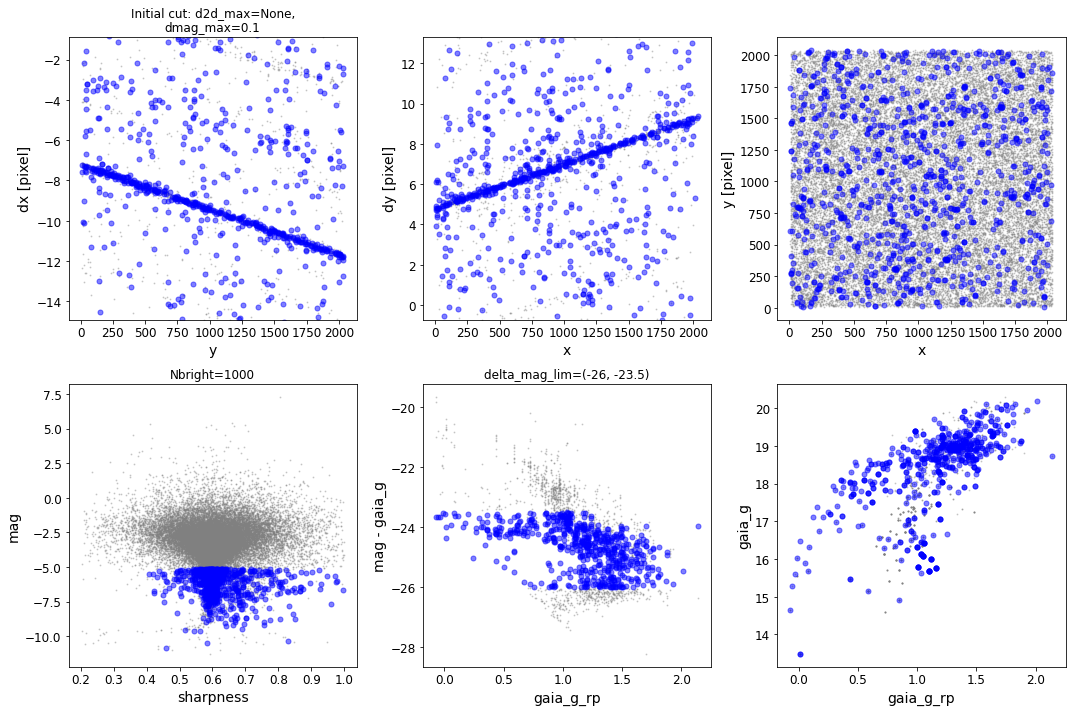

In [29]:
# show the initial dx, dy, centered around their respective medians
# blue symbols: measurements that make the initial cut using d2d_max, dmag_max, Nbright
# small gray symbols: didn't make the initial cut.
# goal of the initial cuts is to remove enough of the faint, spurious matches so that the
# loci of the good matches sticks at least a little out (visually)
if showplots>1:
    sp = initplot(2,3)
    # plot the residuals
    title = f'Initial cut: d2d_max={d2d_max},\ndmag_max={dmag_max}'
    title_Nbright = f'Nbright={Nbright}'
    title_deltamag = f'delta_mag_lim={delta_mag_lim}'
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('y','dx',ax=sp[0],ylim=dx_plotlim,title=title,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('y','dx',ax=sp[0],ylim=dx_plotlim, ylabel='dx [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','dy',ax=sp[1],ylim=dx_plotlim,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','dy',ax=sp[1],ylim=dy_plotlim,ylabel='dy [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','y',ax=sp[2],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','y',ax=sp[2],ylabel='y [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('sharpness','mag',ax=sp[3],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('sharpness','mag',ax=sp[3],title=title_Nbright,ylabel='mag',**plot_style['good_data'])
    if wcs_align.phot.refcat_mainfilter is not None:
        if wcs_align.phot.refcat_maincolor is not None:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,'delta_mag',ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,'delta_mag',title=title_deltamag,ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],ylabel=f'{wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(6): sp[i].get_legend().remove()
        else:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',title=title_deltamag,ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(5): sp[i].get_legend().remove()
    else:
        for i in range(4): sp[i].get_legend().remove()

    plt.tight_layout()
    plt.show() 

hello
        slope     intercept        maxval  index  d_bestguess  fwhm  multimax
-4.882812e-03  5.000000e+00  43857.665146    294    -9.100074   0.4     False
-4.833984e-03  4.950000e+00  44695.497196    294    -9.132003   0.4     False
-4.785156e-03  4.900000e+00  44978.701428    294    -9.163933   0.4     False
-4.736328e-03  4.850000e+00  44409.983098    294    -9.195862   0.4     False
-4.687500e-03  4.800000e+00  44778.797118    294    -9.227792   0.4     False
-4.638672e-03  4.750000e+00  45160.184105    294    -9.259721   0.4     False
-4.589844e-03  4.700000e+00  44862.419897    294    -9.291651   0.4     False
-4.541016e-03  4.650000e+00  28637.701472    294    -9.323580   0.6     False
-4.492188e-03  4.600000e+00  42746.975533    295    -9.155510   0.4     False
-4.443359e-03  4.550000e+00  43680.784622    295    -9.187439   0.4     False
-4.394531e-03  4.500000e+00  44409.444870    295    -9.219369   0.4     False
-4.345703e-03  4.450000e+00  45701.992779    295    -9.251


####################
### d_rotated cut
Keeping 376 out of 376, skippin 0 because of null values in columns d_rot_tmp
median: -9.490142
65.000000 percentile cut: max residual for cut: 0.094091
median: -9.490142
i:00 mean:-9.490142(0.003144) stdev:0.049004(0.002218) X2norm:1.00 Nchanged:0 Ngood:244 Nclip:132

mean: -9.488276
i:01 mean:-9.488276(0.003865) stdev:0.066037(0.002728) X2norm:1.00 Nchanged:49 Ngood:293 Nclip:83

mean: -9.487350
i:02 mean:-9.487350(0.004366) stdev:0.077357(0.003082) X2norm:1.00 Nchanged:22 Ngood:315 Nclip:61

mean: -9.486823
i:03 mean:-9.486823(0.004729) stdev:0.085246(0.003338) X2norm:1.00 Nchanged:11 Ngood:326 Nclip:50

mean: -9.487597
i:04 mean:-9.487597(0.004856) stdev:0.087954(0.003429) X2norm:1.00 Nchanged:3 Ngood:329 Nclip:47

mean: -9.488384
i:05 mean:-9.488384(0.004905) stdev:0.088977(0.003463) X2norm:1.00 Nchanged:1 Ngood:330 Nclip:46

mean: -9.489186
i:06 mean:-9.489186(0.004956) stdev:0.090032(0.003499) X2norm:1.00 Nchanged:1 Ngood:331 Nclip:45

mea

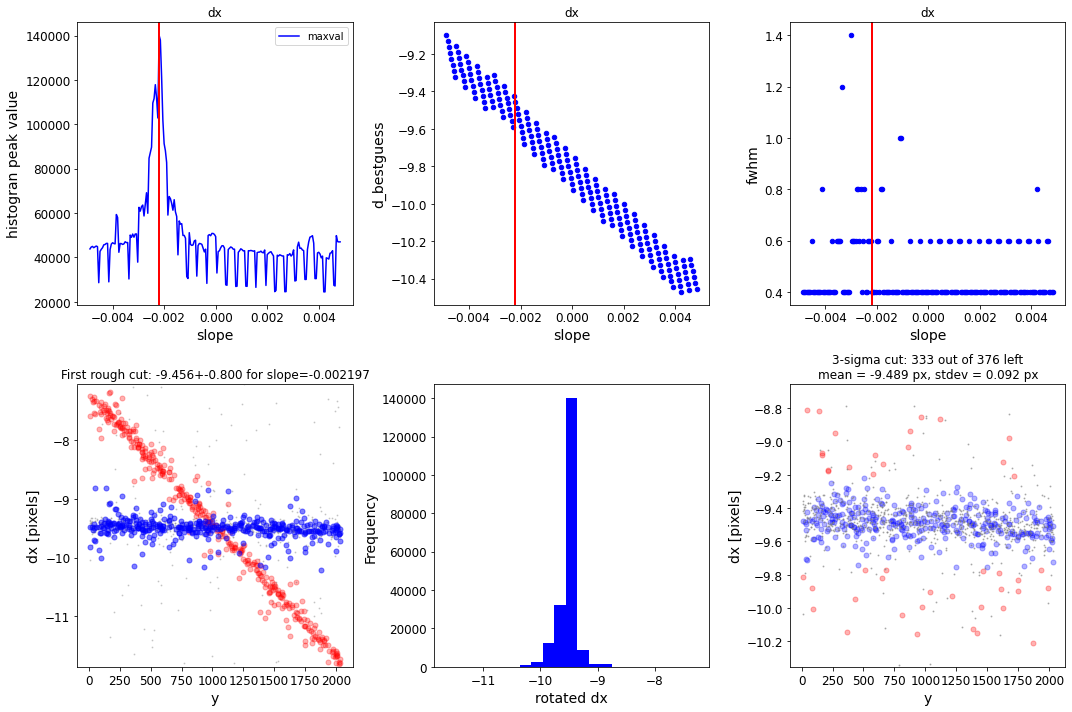

In [35]:
# straight line.
def f(val,slope,intercept):
    return(val*slope+intercept)
import numpy as np
from pdastro import AnotB
def sigmacut_d_rot(phot,ixs,
                   d_col,col,
                   slope,intercept,d_rot_bestguess,
                   rough_cut_px = 2.5, #This is the first rough cut:  get rid of everything d_rot_bestguess+-rough_cut_px
                   d_col_rot='d_rot_tmp',
                   binsize=0.5,
                   bin_weights_flag=True,
                   showplots=0,
                   sp=None,
                   spi=[0,1,2]):

    #phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)
    ### recover the slope and intercept of the best binning
    phot.t[d_col_rot] = phot.t[d_col] - f(phot.t[col],slope,intercept)
    
    # Now make the rough cut! only keep data for with dx_rotated within  d_rot_bestguess+-rough_cut_px
    ixs_roughcut = phot.ix_inrange(d_col_rot,d_rot_bestguess-rough_cut_px,d_rot_bestguess+rough_cut_px,indices=ixs)
    d_rotated = phot.t.loc[ixs,d_col_rot]
    
    if showplots>1:
        if sp is None:
            sp=initplot(1,3)

        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        plot_rotated(phot,ixs_roughcut,
                     d_col,col,
                     d_col_rot=d_col_rot,
                     sp=sp,
                     spi=spi[:2],
                     bins=bins,
                     bin_weights_flag=bin_weights_flag,
                     histolim = (d_rot_bestguess-3*rough_cut_px,d_rot_bestguess+3*rough_cut_px),
                     title=f'First rough cut: {d_rot_bestguess:.3f}+-{rough_cut_px:.3f} for slope={slope:.6f}')

    print('\n####################\n### d_rotated cut')
    #ixs_clean4average = phot_clear.ix_inrange(d_col,0,3,indices=ixs_clear_cut)
    phot.calcaverage_sigmacutloop(d_col_rot,verbose=3,indices=ixs_roughcut,percentile_cut_firstiteration=65)
    print(phot.statstring())
    ixs_cut = phot.statparams['ix_good']

    if showplots>1:
        title = f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left\n'
        title += f'mean = {phot.statparams["mean"]:.3f} px, stdev = {phot.statparams["stdev"]:.3f} px'
        phot.t.loc[AnotB(ixs_roughcut,ixs_cut)].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='red', ms=5 ,alpha=0.3,title=title)
        phot.t.loc[ixs_cut].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='blue', 
                                 ms=5 ,alpha=0.3,ylabel=f'{d_col} [pixels]',
                                 title=title)
        if phot.ixs_notuse is not None:
            phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,style='o',ax=sp[spi[2]],color='gray', ms=1,alpha=0.5)
        sp[spi[2]].get_legend().remove()
    
        # set the appropriate y-axis limits
        (ylim_min,ylim_max) = (phot.t.loc[ixs_roughcut,d_col_rot].min(),phot.t.loc[ixs_roughcut,d_col_rot].max())
        ylim_min -= 0.1*(ylim_max-ylim_min)
        ylim_max += 0.1*(ylim_max-ylim_min)
        sp[spi[2]].set_ylim(ylim_min,ylim_max)
        #sp[spi[2]].set_ylim(sp[spi[2]].get_ylim(),(ylim_min,ylim_max))
        
        
        #phot.t.loc[ixs_roughcut].plot.scatter(col,d_col_rot,ax=sp[spi[2]],color='red')
        #phot.t.loc[ixs_cut].plot.scatter(col,d_col_rot,ax=sp[spi[2]],color='blue',
        #                                 ylabel='dx in pixels',
        #                                 title=f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left')
    return(ixs_cut,ixs_roughcut)

# plot the rotated dx or dy versus the original one
def plot_rotated(phot,ixs,d_col,col,
                 d_col_rot='d_rot_tmp',
                 sp=None,
                 spi=[0,1],
                 histolim=(-20,20),
                 bins=None,
                 bin_weights_flag=False,
                 title=None):
    if sp == None:
        sp=initplot(1,2)

    if phot.ixs_notuse is not None:
        phot.t.loc[phot.ixs_notuse].plot(col,d_col_rot,ax=sp[spi[0]],**plot_style['do_not_use_data'])
    phot.t.loc[ixs].plot(col,d_col,ax=sp[spi[0]],ylim=histolim,title=title,**plot_style['cut_data'])
    phot.t.loc[ixs].plot(col,d_col_rot,ax=sp[spi[0]],ylim=histolim,ylabel=f'{d_col} [pixels]',**plot_style['good_data'])
    sp[spi[0]].get_legend().remove()

    
    if bins is not None:
        if bin_weights_flag:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,
                                                weights=phot.t.loc[ixs,'__weights'],
                                                xlim=histolim,color='blue')
        else:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[spi[1]],bins=bins,xlim=histolim,color='blue')
        sp[spi[1]].set_xlabel(f'rotated {d_col}')
        #sp[spi[1]].get_legend().remove()
    return(sp)


# first, do the dx cut, since dx does not have the same contamination by shadow locii due to 
# the star spikes than dy.
slope_max=-slope_min
slope_stepsize=(slope_max-slope_min)/slope_Nsteps

# initialize dx plot
if showplots>1:
    sp=initplot(2,3)
else:
    sp=None
(dx_rot_results,dx_best_index) = rotate_d_and_find_binmax(wcs_align.phot,ixs,'dx','y',
                                                          Ny,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize,
                                                          showplots=showplots,
                                                          sp=sp,
                                                          spi=[0,1,2])


# Using the best dx_rotated, we first remove all entries with dx_rotated outside of dx_bestguess+-Nfwhm*fwhm
# Note that FWHM ~ 2.355 stdev, so Nfwhm*fwhm should be at least 3*stdev. This is the first ROUGH cut, with 
# which we just want to remove excessive amounts of outliers. Then a 3-sigma cut is done on the *rotated* dx
(ixs_dx_cut,ixs_dx_roughcut) = sigmacut_d_rot(wcs_align.phot,ixs,'dx','y',
                                              dx_rot_results.t.loc[dx_best_index,'slope'],
                                              dx_rot_results.t.loc[dx_best_index,'intercept'],
                                              dx_rot_results.t.loc[dx_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dx_rot_results.t.loc[dx_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots,
                                              sp=sp,
                                              spi=[3,4,5]
                                              )
plt.tight_layout()        

# top plots: histogram peak value, best guess of rotated dx offset, and fwhm with respect to the slopes.
# The red line indicates the best slope
# bottom plots:
# first rough cut is best guess of rotated dx offset +- Nfwhm*fwhm
# bottom left: red is dx, blue is the best rotated dx. small gray circles did not make initial cut
# bottom middle: histogram of rotated dx: this peak value should be the same as the peak in top left plot
# bottom right: 3-sigma cut getting rid of outliers still in the rough cut

hello
   slope  intercept        maxval  index  d_bestguess  fwhm  multimax
0.001709      -1.75  39954.702745    200     7.162031   0.8     False
0.001719      -1.76  40143.188701    200     7.159670   1.0     False
0.001729      -1.77  41006.868694    200     7.157308   0.8     False
0.001738      -1.78  41385.854295    200     7.154947   0.8     False
0.001748      -1.79  41938.271177    200     7.152585   0.8     False
0.001758      -1.80  41784.789713    200     7.150224   0.8     False
0.001768      -1.81  41784.789713    200     7.147862   0.8     False
0.001777      -1.82  42213.355277    200     7.145501   0.8     False
0.001787      -1.83  42213.355277    200     7.143139   1.0     False
0.001797      -1.84  42520.324383    200     7.140778   1.0     False
0.001807      -1.85  44100.848229    200     7.138416   0.8     False
0.001816      -1.86  43965.121421    200     7.136055   0.8     False
0.001826      -1.87  51882.829477    200     7.133693   0.6     False
0.001836      

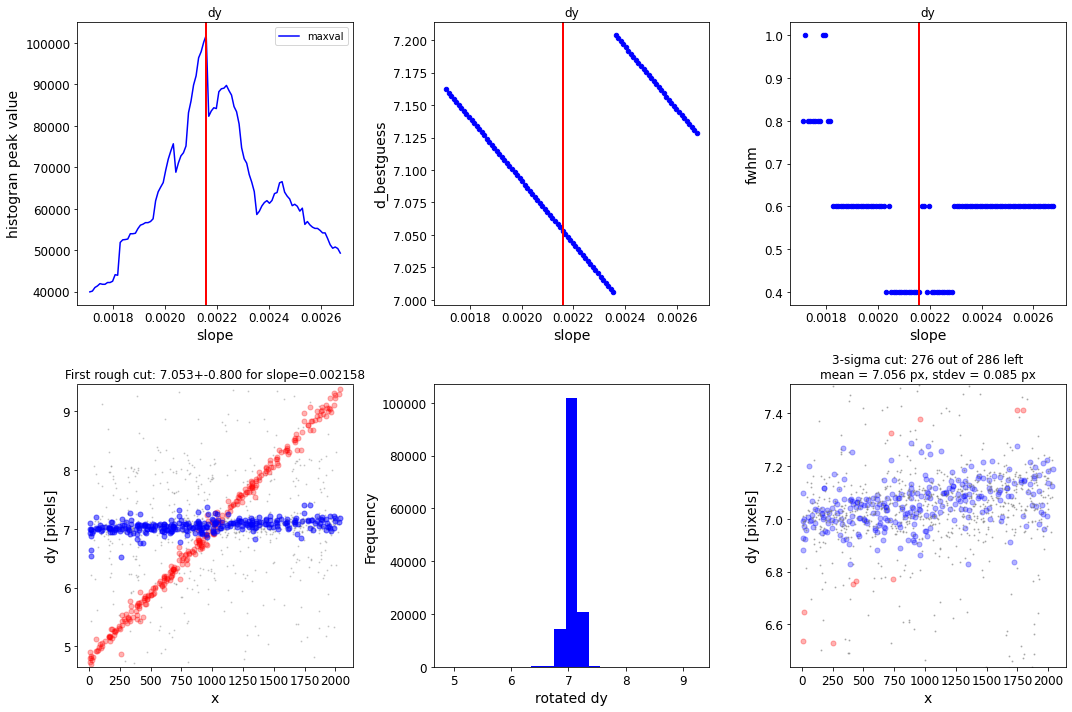

In [37]:
# Using the indices after the dx cut, we now also do a dy cut
# slope in dy is the -slope of dx.
slope = -dx_rot_results.t.loc[dx_best_index,'slope']
# We only need to do it +-10*stepsize
slope_min = slope-10*slope_stepsize
slope_max = slope+10*slope_stepsize

# initialize dy plot
if showplots>1:
    sp=initplot(2,3)
else:
    sp=None
(dy_rot_results,dy_best_index) = rotate_d_and_find_binmax(wcs_align.phot,ixs_dx_cut,'dy','x',
                                                          Nx,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize/5.0,
                                                          showplots=showplots,
                                                          sp=sp,
                                                          spi=[0,1,2])
(ixs_dy_cut,ixs_dy_roughcut) = sigmacut_d_rot(wcs_align.phot,ixs_dx_cut,'dy','x',
                                              dy_rot_results.t.loc[dy_best_index,'slope'],
                                              dy_rot_results.t.loc[dy_best_index,'intercept'],
                                              dy_rot_results.t.loc[dy_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dy_rot_results.t.loc[dy_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots,
                                              sp=sp,
                                              spi=[3,4,5]
                                              )
plt.tight_layout()        


In [38]:

if savephottable:
    print(f'Saving {outbasename}.good.phot.txt')
    wcs_align.phot.write(f'{outbasename}.good.phot.txt',indices=ixs_dy_cut)
    if savephottable>1:
        print(f'Saving {outbasename}.all.phot.txt')
        wcs_align.phot.write(f'{outbasename}.all.phot.txt')

#if showplots>1:
#    # get the bad data points
#    infoplots(wcs_align.phot,ixs_dy_cut,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)
            



Saving /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.good.phot.txt
Saving /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_assignwcsstep.all.phot.txt


In [39]:
# Now align to the reference catalog ONLY using the best matches after the dy cut
# This alignment is done using a hacked version of tweakreg by Justin Pierel: only the part of tweakreg
# is used that does the rshift (rotation+translation) FITTING (only the fitting, no matching! 
# It uses the matches from wcs_align.phot.t[ixs_bestmatch])
ixs_bestmatch = ixs_dy_cut
(runflag,tweakregfilename) = wcs_align.run_align2refcat(calimname,ixs=ixs_bestmatch,
                                                   overwrite=overwrite,skip_if_exists=skip_if_exists)
print('DONE!')


2022-07-02 17:47:53,810 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


/Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_tweakregstep.fits
Setting output directory for tweakregstep.fits file to /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats
276 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=gaia_ra,gaia_dec


2022-07-02 17:47:54,259 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01069002004_02101_00002_nrcblong_assignwcsstep.fits>],).
2022-07-02 17:47:54,263 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 50, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 10, 'searchrad': 0.5, 'use2dhist': True, 'separation': 9, 'tolerance': 0.7, 'xoffset': 0, 'yoffset': 0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 30, 's

DONE!


hello
Index(['aper_sum_4.6px', 'annulus_median_4.6px', 'aper_bkg_4.6px',
       'aper_sum_bkgsub_4.6px', 'flux_err_4.6px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'ra', 'dec', 'x_idl', 'y_idl',
       'gaia_ra', 'gaia_dec', 'gaia_x', 'gaia_y', 'gaia_ID', 'gaia_source_id',
       'gaia_ra_error', 'gaia_dec_error', 'gaia_g', 'gaia_g_err', 'gaia_rp',
       'gaia_rp_err', 'gaia_g_rp', 'gaia_g_rp_err', 'gaia_d2d', 'dx', 'dy',
       'delta_mag', '__weights', 'd_rot_tmp', '__tmp_residuals'],
      dtype='object')
Saving /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_tweakregstep.phot.prewcs.png
Saving /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01069002004_02101_00002_nrcblong_tweakregstep.good.phot.txt
hello
Index(['aper_sum_4.6px', 'annulus_median_4.6px', 'aper_bkg_4.6px',
       'aper_sum_bkgsub_4.6px', 'flux_err_4.6px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundn

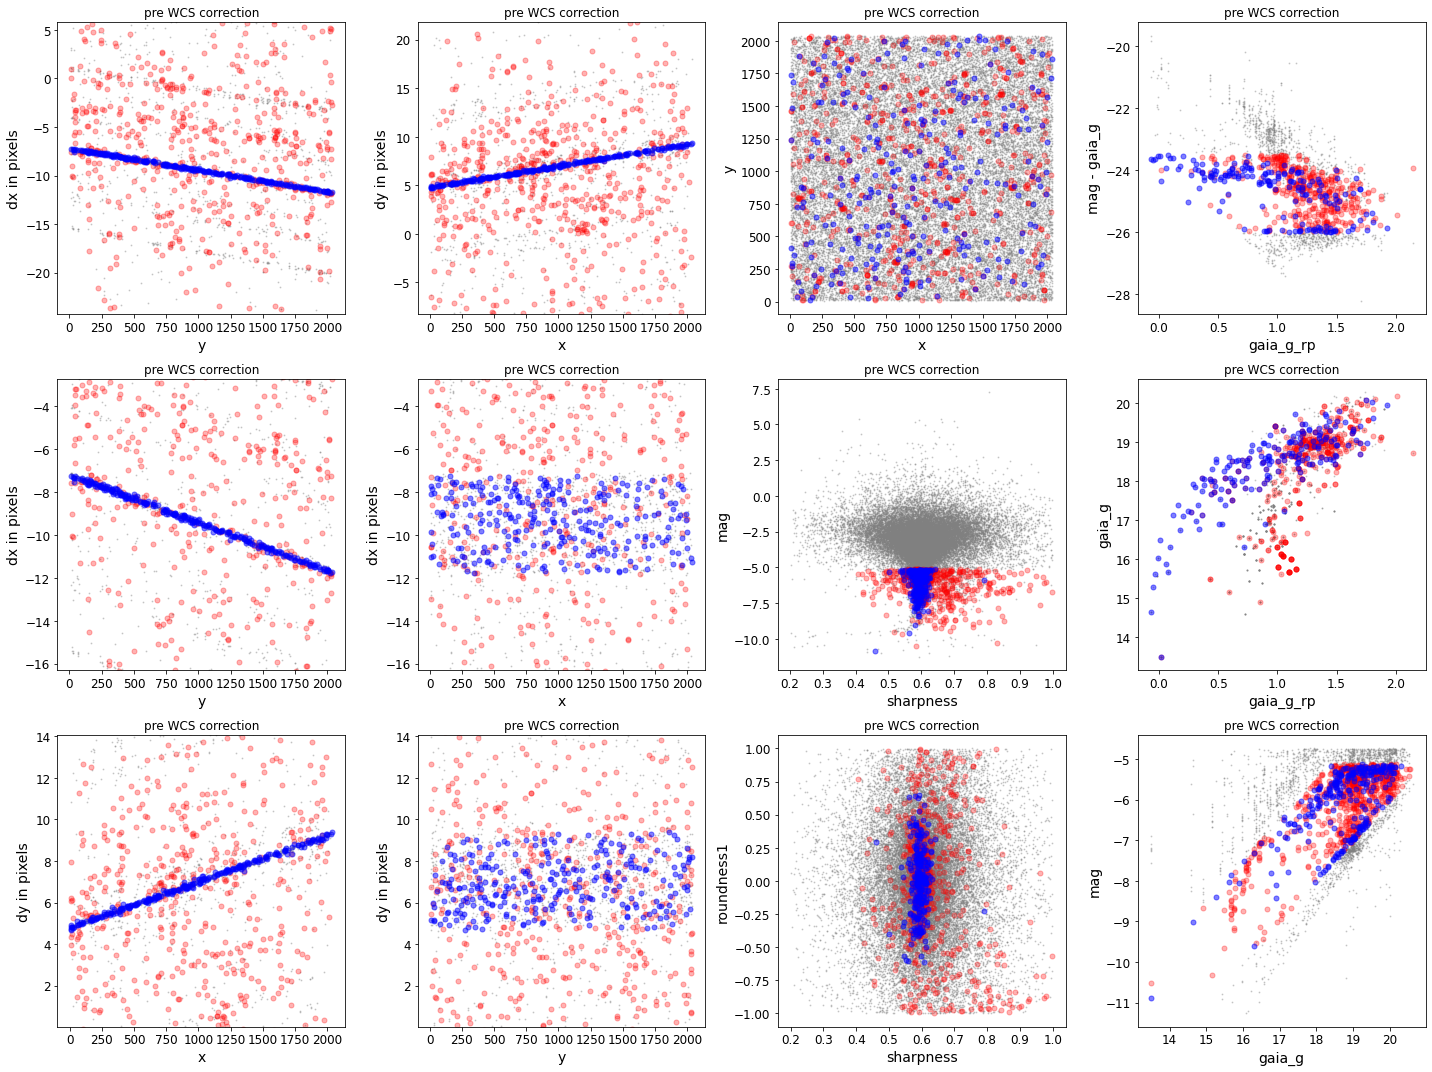

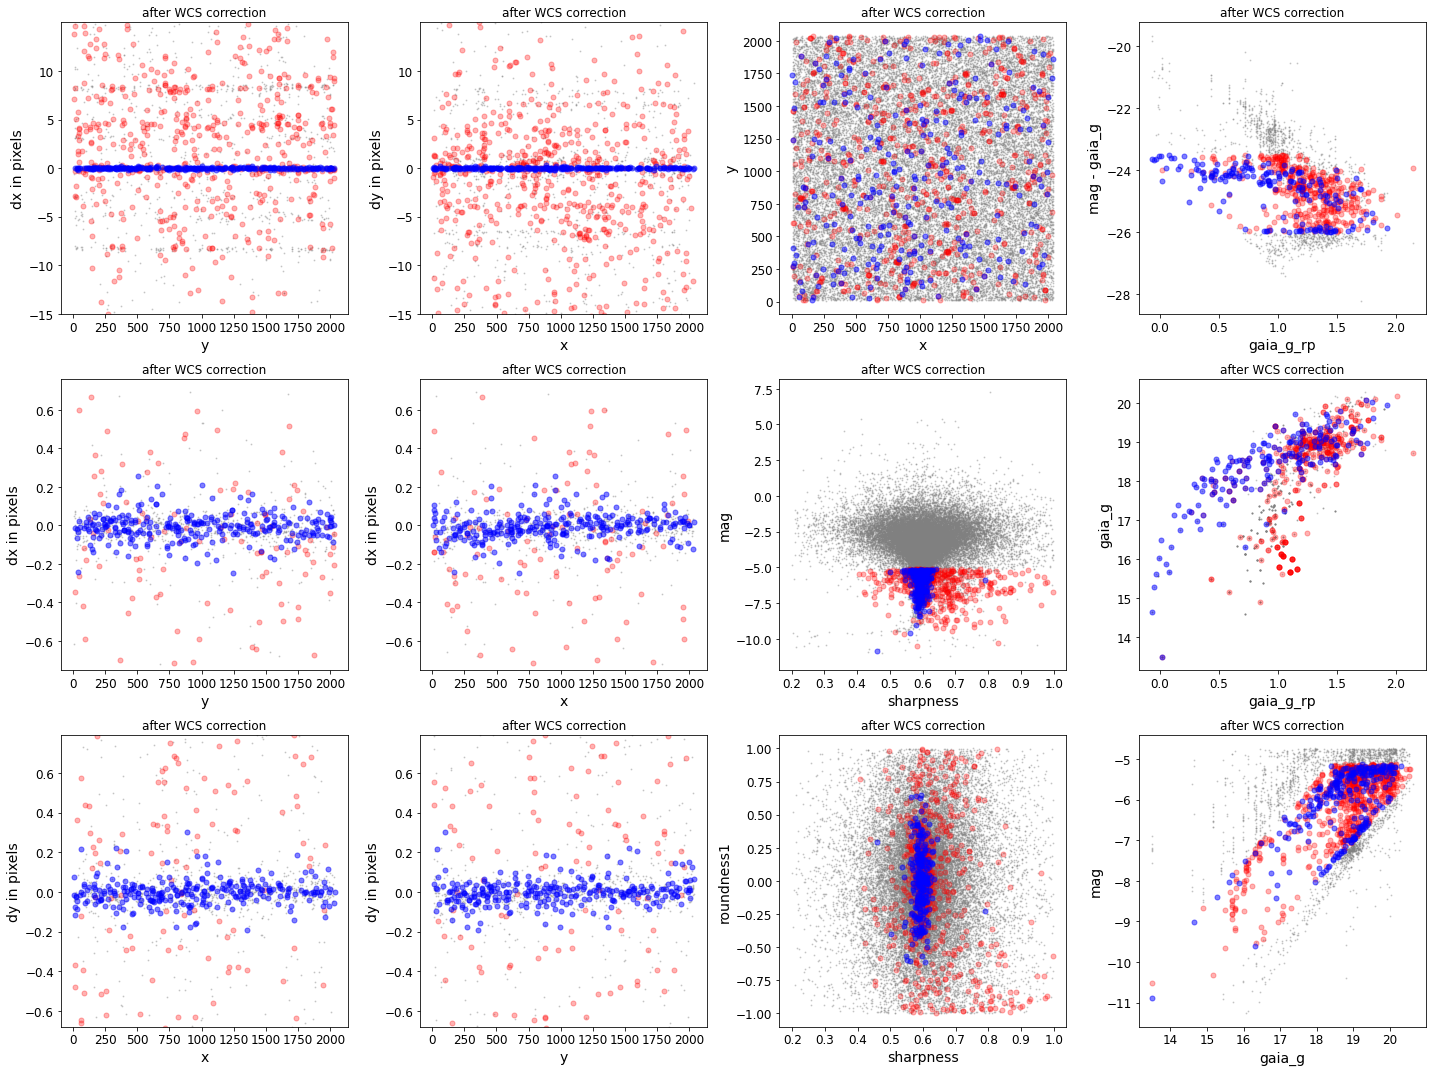

In [40]:

wcs_align.update_phottable_final_wcs(tweakregfilename,
                                ixs_bestmatch = ixs_bestmatch,
                                showplots=showplots,
                                saveplots=saveplots,
                                savephottable=savephottable,
                                overwrite=overwrite
                                )


In [12]:
#####  IGNORE BELOW!!! TESTING!!!
import copy
bkp = copy.deepcopy(wcs_align)

In [13]:
wcs_align = copy.deepcopy(bkp)
print(wcs_align.phot.t.columns,wcs_align.phot.refcatshort)
for col in wcs_align.phot.t.columns:
    if re.search(f'^{wcs_align.phot.refcatshort}',col) is not None:
        wcs_align.phot.t.drop(columns=[col],inplace=True)
        print(col)
    if re.search(f'^_',col) is not None:
        wcs_align.phot.t.drop(columns=[col],inplace=True)
        print(col)
for col in ['ra','dec','dx','dy','d_rot_tmp','delta_mag']:
    if col in wcs_align.phot.t.columns:
        wcs_align.phot.t.drop(columns=[col],inplace=True)
   
print('Done!')
print(wcs_align.phot.t.columns,wcs_align.phot.refcatshort)


Index(['aper_sum_4.6px', 'annulus_median_4.6px', 'aper_bkg_4.6px',
       'aper_sum_bkgsub_4.6px', 'flux_err_4.6px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'ra', 'dec', 'x_idl', 'y_idl',
       'hawki_ra', 'hawki_dec', 'hawki_ID', 'hawki_ra_error_mas',
       'hawki_dec_error_mas', 'hawki_J2mag', 'hawki_K2mag', 'hawki_J2_K2',
       'delta_mag', '__weights', 'd_rot_tmp', '__tmp_residuals', 'hawki_x',
       'hawki_y', 'dx', 'dy'],
      dtype='object') hawki
hawki_ra
hawki_dec
hawki_ID
hawki_ra_error_mas
hawki_dec_error_mas
hawki_J2mag
hawki_K2mag
hawki_J2_K2
__weights
__tmp_residuals
hawki_x
hawki_y
Done!
Index(['aper_sum_4.6px', 'annulus_median_4.6px', 'aper_bkg_4.6px',
       'aper_sum_bkgsub_4.6px', 'flux_err_4.6px', 'mag', 'dmag', 'x', 'y',
       'sharpness', 'roundness1', 'roundness2', 'x_idl', 'y_idl'],
      dtype='object') hawki


In [15]:
print(tweakregfilename)
wcs_align.phot.run_phot(tweakregfilename,do_photometry_flag=False,
                 photcat_loaded = True,rematch_refcat=True,refcatname='hawki')

/Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01074003001_04101_00002_nrcb3_tweakregstep.fits

### Doing photometry on /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01074003001_04101_00002_nrcb3_tweakregstep.fits
NO photometry catalog filename
Filename: /Users/arest/nircam/jwst_distortions_tools/wcs_align/test_newrefcats/jw01074003001_04101_00002_nrcb3_tweakregstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     351   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU       

########### !!!!!!!!!! SHARPNESS =(0.4, 1.0)CUT!!!
########### !!!!!!!!!! delta_mag_lim=(-26, -22) CUT!!!
# of matched objects that pass initial cuts: 1000
Nx:2048 Ny:2048
dx median: 0.08544285285267961
dy median: 0.029987463860322805
hello


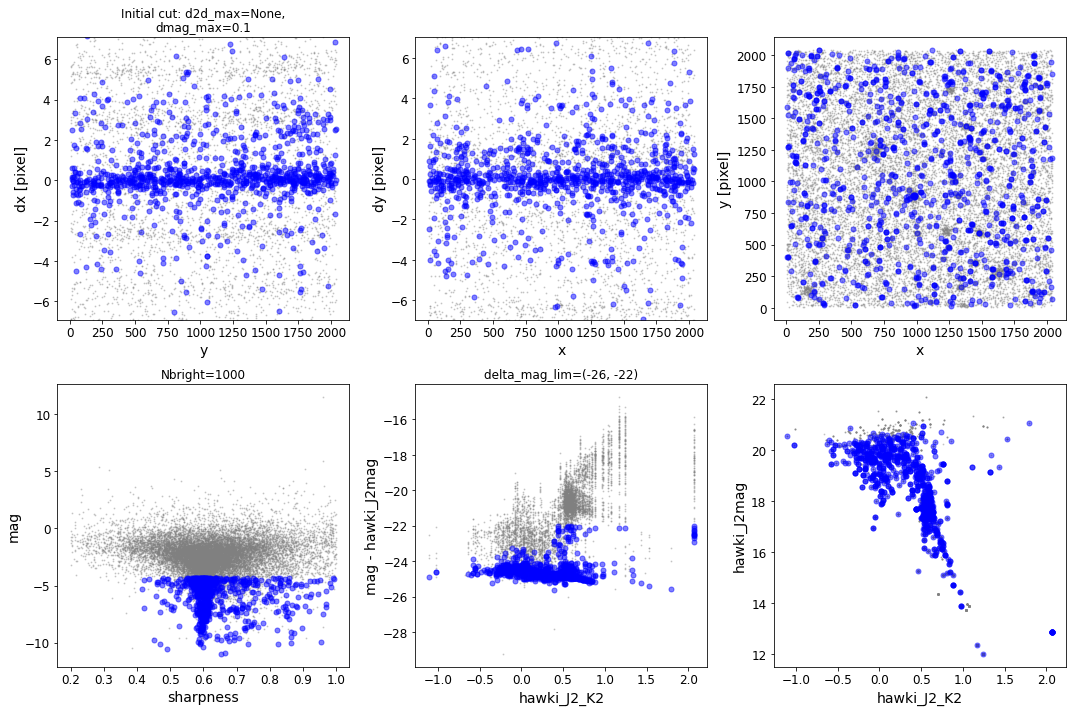

In [16]:
# Now we find good refcat matches. This is 
# done in jwst_wcs_align.find_good_refcat_matches(), but 
# we will do it below step by step, since this is the most
# important step in this process

# here are a few more fine-tuning parameters

# The y-axes limits of the first plots are the mean of dx/dy +-plots_dxdy_delta_pix_ylim
plots_dxdy_delta_pix_ylim=7

# histo parameters
binsize_px = 0.2 # this is the binsize of the dx/dy histograms. 
                 # A good value is 0.1, which should be on the order 
                 # of the expected stdev of dx if things are good
bin_weights_flag=True # If bin_weights_flag is set to True, 
                      # then the dx/dy bins are weighted by 
                      # the flux of the detection. This enhances 
                      # the signal in the histogram since real 
                      # matches in general have more flux than spurious matches

# dx/dy are corrected by a linear function with a slope (i.e., the effect a rotation would have on it), and 
# then a histogram of this "rotated" dx/dy is done, and the peak of that
# histogram is determined. This is done for a set of slopes, which is defined
# with slope_min, slope_Nsteps, and then 
# slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
# slope=-10.0/2048.0 would correspond to the slope of a linear function for wich dx changes by 
# 10 pixels of the full detector size of 2048 pixels
slope_min=-10.0/2048.0 
slope_Nsteps = 200 # slope_max=-slope_min, slope_stepsize=(slope_max-slope_min)/slope_Nsteps
Nfwhm = 2

# basename for output files, e.g., plots
outbasename = re.sub('\.fits$','',calimname)
if (outbasename == calimname): raise RuntimeError(f'Could not remove .fits from {calimname}')        

# use all the data in the photometric catalog if ixs=None
ixs=None

if (saveplots or savephottable) and (outbasename is None):
    raise RuntimeError('Trying to save plots and/or phot tables, but outbasename is None!')

Nx = wcs_align.phot.scihdr['NAXIS1']
Ny = wcs_align.phot.scihdr['NAXIS2']

refcat_xcol = wcs_align.phot.refcat_xcol
refcat_ycol = wcs_align.phot.refcat_ycol
xcol='x'
ycol='y'

# Calculate dx and dy
wcs_align.phot.t['dx'] = wcs_align.phot.t[refcat_xcol] - wcs_align.phot.t[xcol]
wcs_align.phot.t['dy'] = wcs_align.phot.t[refcat_ycol] - wcs_align.phot.t[ycol]
# Calculate the difference between JWST mag and main filter of reference catalog
if wcs_align.phot.refcat_mainfilter is not None:
    wcs_align.phot.t['delta_mag'] = wcs_align.phot.t['mag'] - wcs_align.phot.t[wcs_align.phot.refcat_mainfilter]

sharpness_lim = (0.4,1.0)
delta_mag_lim=(-26, -22)
# do some first very rough cuts.
# sets phot.ixs_use and phot.ixs_notuse
# returns phot.ixs_use
ixs = wcs_align.initial_cut(phot=wcs_align.phot,
                       d2d_max=d2d_max,
                       dmag_max=dmag_max,
                       Nbright=Nbright,
                       sharpness_lim=sharpness_lim,
                       delta_mag_lim=delta_mag_lim,
                       ixs=ixs)

dx_median = wcs_align.phot.t.loc[ixs,'dx'].median()
dy_median = wcs_align.phot.t.loc[ixs,'dy'].median()

if wcs_align.verbose>1: print(f'Nx:{Nx} Ny:{Ny}\ndx median: {dx_median}\ndy median: {dy_median}')

# these are the general limits for the y-axis for the dx/dy plots
dy_plotlim = (dy_median-plots_dxdy_delta_pix_ylim,dy_median+plots_dxdy_delta_pix_ylim)
dx_plotlim = (dx_median-plots_dxdy_delta_pix_ylim,dx_median+plots_dxdy_delta_pix_ylim)

plot_style={}
plot_style['good_data']={'style':'o','color':'blue', 'ms':5 ,'alpha':0.5}
plot_style['cut_data']={'style':'o','color':'red', 'ms':5 ,'alpha':0.3}
plot_style['do_not_use_data']={'style':'o','color':'gray', 'ms':1 ,'alpha':0.3}
# show the initial dx, dy, centered around their respective medians
# blue symbols: measurements that make the initial cut using d2d_max, dmag_max, Nbright
# small gray symbols: didn't make the initial cut.
# goal of the initial cuts is to remove enough of the faint, spurious matches so that the
# loci of the good matches sticks at least a little out (visually)
if showplots>1:
    sp = initplot(2,3)
    # plot the residuals
    title = f'Initial cut: d2d_max={d2d_max},\ndmag_max={dmag_max}'
    title_Nbright = f'Nbright={Nbright}'
    title_deltamag = f'delta_mag_lim={delta_mag_lim}'
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('y','dx',ax=sp[0],ylim=dx_plotlim,title=title,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('y','dx',ax=sp[0],ylim=dx_plotlim, ylabel='dx [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','dy',ax=sp[1],ylim=dx_plotlim,**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','dy',ax=sp[1],ylim=dy_plotlim,ylabel='dy [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('x','y',ax=sp[2],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('x','y',ax=sp[2],ylabel='y [pixel]',**plot_style['good_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot('sharpness','mag',ax=sp[3],**plot_style['do_not_use_data'])
    wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot('sharpness','mag',ax=sp[3],title=title_Nbright,ylabel='mag',**plot_style['good_data'])
    if wcs_align.phot.refcat_mainfilter is not None:
        if wcs_align.phot.refcat_maincolor is not None:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,'delta_mag',ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,'delta_mag',title=title_deltamag,ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_maincolor,wcs_align.phot.refcat_mainfilter,ax=sp[5],ylabel=f'{wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(6): sp[i].get_legend().remove()
        else:
            wcs_align.phot.t.loc[wcs_align.phot.ixs_notuse].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',title=title_deltamag,ax=sp[4],**plot_style['do_not_use_data'])
            wcs_align.phot.t.loc[wcs_align.phot.ixs_use].plot(wcs_align.phot.refcat_mainfilter,'delta_mag',ax=sp[4],ylabel=f'mag - {wcs_align.phot.refcat_mainfilter}',**plot_style['good_data'])
            for i in range(5): sp[i].get_legend().remove()
    else:
        for i in range(4): sp[i].get_legend().remove()

    plt.tight_layout()
    plt.show() 